In [1]:
import csv
import pandas as pd
import numpy as np

df=pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_train.csv')
#pixel value statistics

print(f"Min pixel value: {df.iloc[:, 1:].min().min()}")
print(f"Max pixel value: {df.iloc[:, 1:].max().max()}")
print(f"Mean pixel value: {df.iloc[:, 1:].mean().mean():.2f}")
print(f"Std pixel value: {df.iloc[:, 1:].std().mean():.2f}")

Min pixel value: 0
Max pixel value: 255
Mean pixel value: 72.96
Std pixel value: 70.04


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images from the DataFrame
def display_images(df, indices, figsize=(12, 8)):
    """
    Display multiple images in a grid layout
    
    Args:
        df: DataFrame containing the CSV data
        indices: List of row indices to display
        figsize: Figure size for the plot
    """
    n_images = len(indices)
    cols = min(5, n_images)  # Maximum 5 columns
    rows = (n_images + cols - 1) // cols  # Calculate rows needed
    
    plt.figure(figsize=figsize)
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        
        # Get the label and pixel data
        label = df.iloc[idx, 0]
        pixels = df.iloc[idx, 1:].values
        image = pixels.reshape(28, 28)
        
        plt.imshow(image, cmap='gray')
        plt.title(f'Index: {idx}, Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# class names 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']    


Displaying one example from each class:


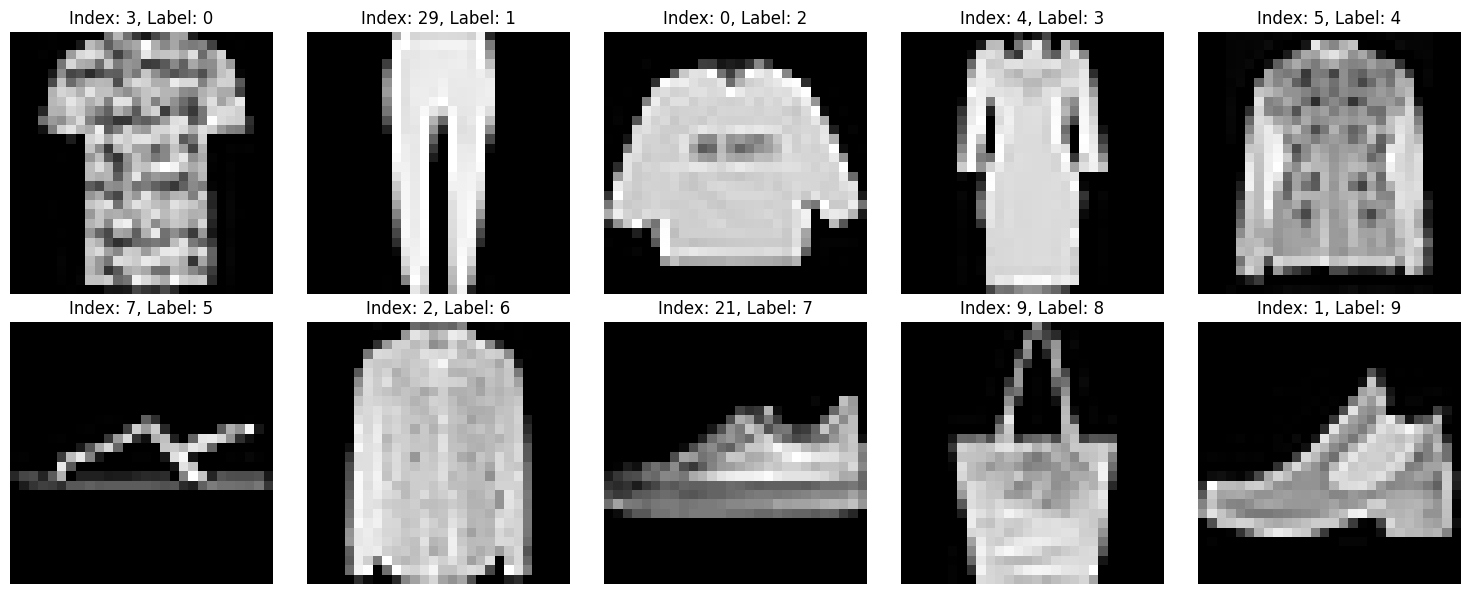

In [3]:
print("\nDisplaying one example from each class:")
one_per_class = []
for class_label in range(10):
    # collect indices of first occurrence of each class
    class_indices = df[df['label'] == class_label].index
    if len(class_indices) > 0:
        one_per_class.append(class_indices[0])
#display images 
display_images(df, one_per_class, figsize=(15, 6))        

In [4]:
# Load the test set
df_test = pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_test.csv')
print(f"Test dataset shape: {df_test.shape}")



Test dataset shape: (10000, 785)


In [5]:
# define function to hide pixels at random
def hide_random(df, hide_ratio=0.75):
 
    # Create a copy of the dataframe
    df_hidden = df.copy()
    
    # For each image randomly select pixels to hide
    for i in range(len(df_hidden)):
        # Get pixel columns 
        pixel_cols = df_hidden.columns[1:]
        n_pixels = len(pixel_cols)
        n_to_hide = int(n_pixels * hide_ratio)
        
        # Randomly select which pixels to hide
        pixels_to_hide = np.random.choice(pixel_cols, size=n_to_hide, replace=False)
        
        # Set selected pixels to 0 
        df_hidden.loc[i, pixels_to_hide] = 0
    
    return df_hidden

Original Images:


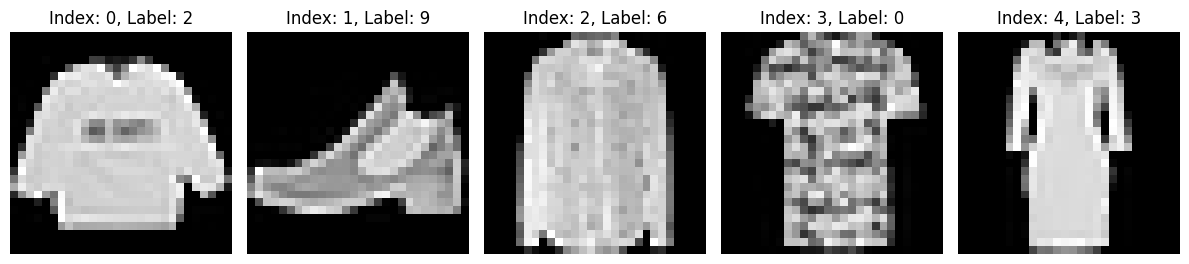

Images with 75% pixels hidden:


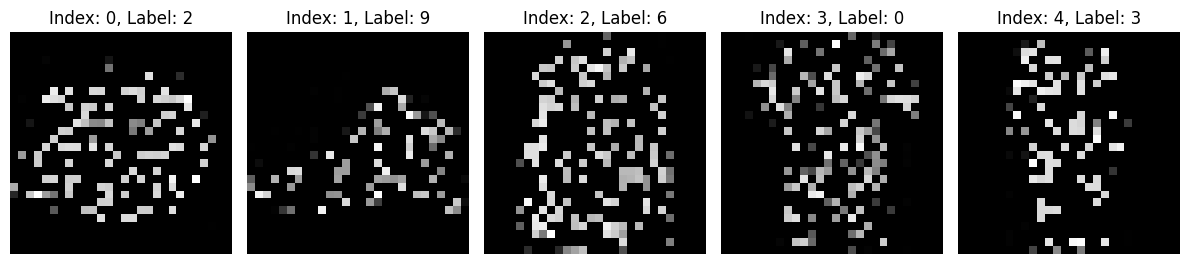

In [6]:
# original vs hidden comparison
df_copy=df.copy()
df_hidden=hide_random(df_copy, hide_ratio=0.75)
print("Original Images:")
display_images(df_copy, list(range(5)), figsize=(12, 6))
print("Images with 75% pixels hidden:")
display_images(df_hidden, list(range(5)), figsize=(12, 6))

In [7]:
#Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB    
from sklearn.metrics import accuracy_score, classification_report

X_train=df.iloc[:, 1:]
y_train=df['label']
X_test=df_test.iloc[:, 1:]
y_test=df_test['label']


model=MultinomialNB()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
print(f"Multinomial Naive Bayes Classifier Accuracy: {accuracy*100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))  


Multinomial Naive Bayes Classifier Accuracy: 66.74%
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.77      0.75      1000
     Trouser       0.97      0.90      0.94      1000
    Pullover       0.63      0.61      0.62      1000
       Dress       0.66      0.90      0.76      1000
        Coat       0.47      0.62      0.53      1000
      Sandal       0.71      0.16      0.26      1000
       Shirt       0.33      0.15      0.20      1000
     Sneaker       0.59      0.90      0.71      1000
         Bag       0.89      0.84      0.86      1000
  Ankle boot       0.69      0.82      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.64     10000
weighted avg       0.67      0.67      0.64     10000



In [9]:
#Multinomial Naive Bayes Classifier on hidden images
from sklearn.naive_bayes import MultinomialNB    
from sklearn.metrics import accuracy_score, classification_report
X_train_hidden=df_hidden.iloc[:, 1:]
y_train_hidden=df_hidden['label']
X_test=df_test.iloc[:, 1:]
y_test=df_test['label']
model=MultinomialNB()
model.fit(X_train_hidden, y_train_hidden)
y_pred_hidden=model.predict(X_test)
accuracy_hidden=accuracy_score(y_test, y_pred_hidden)
print(f"Multinomial Naive Bayes Classifier on Hidden Images Accuracy: {accuracy_hidden*100:.2f}%")
print("Classification Report for Hidden Images:")
print(classification_report(y_test, y_pred_hidden, target_names=class_names))   

Multinomial Naive Bayes Classifier on Hidden Images Accuracy: 66.74%
Classification Report for Hidden Images:
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.77      0.75      1000
     Trouser       0.98      0.90      0.94      1000
    Pullover       0.63      0.61      0.62      1000
       Dress       0.66      0.90      0.76      1000
        Coat       0.46      0.62      0.53      1000
      Sandal       0.71      0.16      0.27      1000
       Shirt       0.33      0.15      0.21      1000
     Sneaker       0.59      0.90      0.71      1000
         Bag       0.89      0.83      0.86      1000
  Ankle boot       0.69      0.82      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.64     10000
weighted avg       0.67      0.67      0.64     10000

